# 1. install the required packages

In [1]:
# 1. install the required packages
!pip install yfinance stable-baselines3 gym numpy pandas matplotlib
!pip install ta-lib


[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: pip install --upgrade pip


# 2. Download the dow jones 30 stocks data

In [2]:
import yfinance as yf
import pandas as pd

# Danh sách các cổ phiếu trong Dow Jones 30
tickers = [
    'MMM', 'AXP', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'DIS', 'DOW',
    'GS', 'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MRK', 'MSFT', 'NKE',
    'PFE', 'PG', 'TRV', 'UNH', 'UTX', 'VZ', 'V', 'WBA', 'WMT', 'XOM'
]

# Lấy dữ liệu lịch sử từ Yahoo Finance và lưu vào dictionary
def get_data(tickers):
    stock_data = {}
    for ticker in tickers:
        df = yf.download(ticker, start="2009-01-01", end="2020-05-08")
        stock_data[ticker] = df
    return stock_data

# Gọi hàm để lấy dữ liệu
stock_data = get_data(tickers)

# Lưu dữ liệu vào file CSV (tuỳ chọn)
for ticker, df in stock_data.items():
    df.to_csv(f'{ticker}.csv')


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

# 3. Load the data from the CSV files

In [3]:
import pandas as pd

# Danh sách các cổ phiếu trong Dow Jones 30
tickers = [
    'MMM', 'AXP', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'DIS', 'DOW',
    'GS', 'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MRK', 'MSFT', 'NKE',
    'PFE', 'PG', 'TRV', 'UNH', 'UTX', 'VZ', 'V', 'WBA', 'WMT', 'XOM'
]

# ticker of benchmark
benchmark = '^DJI'

# Get the data from the CSV files
stock_data = {}
for ticker in tickers:
    df = pd.read_csv(f'{ticker}.csv', index_col='Date', parse_dates=True)
    stock_data[ticker] = df


# split the data into training, validation and test sets
training_data_time_range = ('2009-01-01', '2015-12-31')
validation_data_time_range = ('2016-01-01', '2016-12-31')
test_data_time_range = ('2017-01-01', '2020-05-08')

# split the data into training, validation and test sets
training_data = {}
validation_data = {}
test_data = {}

for ticker, df in stock_data.items():
    training_data[ticker] = df.loc[training_data_time_range[0]:training_data_time_range[1]]
    validation_data[ticker] = df.loc[validation_data_time_range[0]:validation_data_time_range[1]]
    test_data[ticker] = df.loc[test_data_time_range[0]:test_data_time_range[1]]

# print shape of training, validation and test data
ticker = 'AAPL'
print(f'Training data shape for {ticker}: {training_data[ticker].shape}')
print(f'Validation data shape for {ticker}: {validation_data[ticker].shape}')
print(f'Test data shape for {ticker}: {test_data[ticker].shape}')

# Display the first 5 rows of the data
stock_data['AAPL'].head()

Training data shape for AAPL: (1762, 6)
Validation data shape for AAPL: (252, 6)
Test data shape for AAPL: (842, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-01-02,3.067143,3.251429,3.041429,3.241071,2.740172,746015200
2009-01-05,3.327500,3.435000,3.311071,3.377857,2.855818,1181608400
2009-01-06,3.426786,3.470357,3.299643,3.322143,2.808715,1289310400
2009-01-07,3.278929,3.303571,3.223571,3.250357,2.748024,753048800
2009-01-08,3.229643,3.326786,3.215714,3.310714,2.799053,673500800


# 4. Add technical indicators to the data

Function to add technical indicators to the data:

In [4]:
import pandas as pd
import numpy as np

def add_technical_indicators(df):
    # calculate RSI 14 
    delta = df['Close'].diff()
    up = delta.where(delta > 0, 0)
    down = -delta.where(delta < 0, 0)
    rs = up.rolling(window=14).mean() / down.rolling(window=14).mean()
    df['RSI'] = 100 - (100 / (1 + rs))

    # Tính toán EMA 12 và 26 kỳ cho MACD
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    
    # Tính toán RSI 14 kỳ
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # Tính toán CCI 20 kỳ
    tp = (df['High'] + df['Low'] + df['Close']) / 3
    sma_tp = tp.rolling(window=20).mean()
    mean_dev = tp.rolling(window=20).apply(lambda x: np.mean(np.abs(x - x.mean())))
    df['CCI'] = (tp - sma_tp) / (0.015 * mean_dev)
    
    # Tính toán ADX 14 kỳ
    high_diff = df['High'].diff()
    low_diff = df['Low'].diff()
    df['+DM'] = np.where((high_diff > low_diff) & (high_diff > 0), high_diff, 0)
    df['-DM'] = np.where((low_diff > high_diff) & (low_diff > 0), low_diff, 0)
    tr = pd.concat([df['High'] - df['Low'], np.abs(df['High'] - df['Close'].shift(1)), np.abs(df['Low'] - df['Close'].shift(1))], axis=1).max(axis=1)
    atr = tr.ewm(span=14, adjust=False).mean()
    df['+DI'] = 100 * (df['+DM'].ewm(span=14, adjust=False).mean() / atr)
    df['-DI'] = 100 * (df['-DM'].ewm(span=14, adjust=False).mean() / atr)
    dx = 100 * np.abs(df['+DI'] - df['-DI']) / (df['+DI'] + df['-DI'])
    df['ADX'] = dx.ewm(span=14, adjust=False).mean()

    # drop NaN values
    df.dropna(inplace=True)

    # keep Open, High, Low, Close, Volume, MACD, Signal, RSI, CCI, ADX
    df = df[['Open', 'High', 'Low', 'Close', 'Volume', 'MACD', 'Signal', 'RSI', 'CCI', 'ADX']]

    return df


add technical indicators to the data

In [5]:

# add technical indicators to the training data for each stock
for ticker, df in training_data.items():
    training_data[ticker] = add_technical_indicators(df)

# add technical indicators to the validation data for each stock
for ticker, df in validation_data.items():
    validation_data[ticker] = add_technical_indicators(df)

# add technical indicators to the test data for each stock
for ticker, df in test_data.items():
    test_data[ticker] = add_technical_indicators(df)

# print the first 5 rows of the data
print('Shape of training data for AAPL:', training_data['AAPL'].shape)
print('Shape of validation data for AAPL:', validation_data['AAPL'].shape)
print('Shape of test data for AAPL:', test_data['AAPL'].shape)

/var/folders/3h/k_7p78896dn6jjq56w5lrq6m0000gn/T/ipykernel_5587/412413641.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RSI'] = 100 - (100 / (1 + rs))
/var/folders/3h/k_7p78896dn6jjq56w5lrq6m0000gn/T/ipykernel_5587/412413641.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
/var/folders/3h/k_7p78896dn6jjq56w5lrq6m0000gn/T/ipykernel_5587/412413641.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Shape of training data for AAPL: (1743, 10)
Shape of validation data for AAPL: (233, 10)
Shape of test data for AAPL: (823, 10)


/var/folders/3h/k_7p78896dn6jjq56w5lrq6m0000gn/T/ipykernel_5587/412413641.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CCI'] = (tp - sma_tp) / (0.015 * mean_dev)
/var/folders/3h/k_7p78896dn6jjq56w5lrq6m0000gn/T/ipykernel_5587/412413641.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['+DM'] = np.where((high_diff > low_diff) & (high_diff > 0), high_diff, 0)
/var/folders/3h/k_7p78896dn6jjq56w5lrq6m0000gn/T/ipykernel_5587/412413641.py:35: SettingWithCopyWarning: 
A value is trying to be set 

# 5. Create Trading Environment

In [6]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd

class StockTradingEnv(gym.Env):
    metadata = {'render_modes': ['human']}
    
    def __init__(self, stock_data, transaction_cost_percent=0.005):
        super(StockTradingEnv, self).__init__()
        
        # Remove any empty DataFrames
        self.stock_data = {ticker: df for ticker, df in stock_data.items() if not df.empty}
        self.tickers = list(self.stock_data.keys())
        
        if not self.tickers:
            raise ValueError("All provided stock data is empty")
        
        # Calculate the size of one stock's data
        sample_df = next(iter(self.stock_data.values()))
        self.n_features = len(sample_df.columns)
        
        # Define action and observation space
        self.action_space = spaces.Box(low=-1, high=1, shape=(len(self.tickers),), dtype=np.float32)
        
        # Observation space: price data for each stock + balance + shares held + net worth + max net worth + current step
        self.obs_shape = self.n_features * len(self.tickers) + 2 + len(self.tickers) + 2
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.obs_shape,), dtype=np.float32)
        
        # Initialize account balance
        self.initial_balance = 1000
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.max_net_worth = self.initial_balance
        self.shares_held = {ticker: 0 for ticker in self.tickers}
        self.total_shares_sold = {ticker: 0 for ticker in self.tickers}
        self.total_sales_value = {ticker: 0 for ticker in self.tickers}
        
        # Set the current step
        self.current_step = 0
        
        # Calculate the minimum length of data across all stocks
        self.max_steps = max(0, min(len(df) for df in self.stock_data.values()) - 1)

        # Transaction cost
        self.transaction_cost_percent = transaction_cost_percent
    
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.max_net_worth = self.initial_balance
        self.shares_held = {ticker: 0 for ticker in self.tickers}
        self.total_shares_sold = {ticker: 0 for ticker in self.tickers}
        self.total_sales_value = {ticker: 0 for ticker in self.tickers}
        self.current_step = 0
        return self._next_observation(), {}
    
    def _next_observation(self):
        # initialize the frame
        frame = np.zeros(self.obs_shape)
        
        # Add stock data for each ticker
        idx = 0
        # Loop through each ticker
        for ticker in self.tickers:
            # Get the DataFrame for the current ticker
            df = self.stock_data[ticker]
            # If the current step is less than the length of the DataFrame, add the price data for the current step
            if self.current_step < len(df):
                frame[idx:idx+self.n_features] = df.iloc[self.current_step].values
            # Otherwise, add the last price data available
            elif len(df) > 0:
                frame[idx:idx+self.n_features] = df.iloc[-1].values
            # Move the index to the next ticker
            idx += self.n_features

        # Add balance, shares held, net worth, max net worth, and current step
        frame[-4-len(self.tickers)] = self.balance # Balance
        frame[-3-len(self.tickers):-3] = [self.shares_held[ticker] for ticker in self.tickers] # Shares held
        frame[-3] = self.net_worth # Net worth
        frame[-2] = self.max_net_worth # Max net worth
        frame[-1] = self.current_step # Current step
        
        return frame
    
    def step(self, actions):
        # update the current step
        self.current_step += 1
        
        # check if we have reached the maximum number of steps
        if self.current_step > self.max_steps:
            return self._next_observation(), 0, True, False, {}
        
        current_prices = {}
        # Loop through each ticker and perform the action
        for i, ticker in enumerate(self.tickers):
            # Get the current price of the stock
            current_prices[ticker] = self.stock_data[ticker].iloc[self.current_step]['Close']
            # get the action for the current ticker
            action = actions[i]
            
            if action > 0:  # Buy
                # Calculate the number of shares to buy
                shares_to_buy = int(self.balance * action / current_prices[ticker])
                # Calculate the cost of the shares
                cost = shares_to_buy * current_prices[ticker]
                # Transaction cost
                transaction_cost = cost * self.transaction_cost_percent
                # Update the balance and shares held
                self.balance -= (cost + transaction_cost)
                # Update the total shares sold
                self.shares_held[ticker] += shares_to_buy

            elif action < 0:  # Sell
                # Calculate the number of shares to sell
                shares_to_sell = int(self.shares_held[ticker] * abs(action))
                # Calculate the sale value
                sale = shares_to_sell * current_prices[ticker]
                # Transaction cost
                transaction_cost = sale * self.transaction_cost_percent
                # Update the balance and shares held
                self.balance += (sale - transaction_cost)
                # Update the total shares sold
                self.shares_held[ticker] -= shares_to_sell
                # Update the shares sold
                self.total_shares_sold[ticker] += shares_to_sell
                # Update the total sales value
                self.total_sales_value[ticker] += sale
        
        # Calculate the net worth
        self.net_worth = self.balance + sum(self.shares_held[ticker] * current_prices[ticker] for ticker in self.tickers)
        # Update the max net worth
        self.max_net_worth = max(self.net_worth, self.max_net_worth)
        # Calculate the reward
        reward = self.net_worth - self.initial_balance
        # Check if the episode is done
        done = self.net_worth <= 0 or self.current_step >= self.max_steps
        
        obs = self._next_observation()
        return obs, reward, done, False, {}
    
    def render(self, mode='human'):
        # Print the current step, balance, shares held, net worth, and profit
        profit = self.net_worth - self.initial_balance
        print(f'Step: {self.current_step}')
        print(f'Balance: {self.balance:.2f}')
        for ticker in self.tickers:
            print(f'{ticker} Shares held: {self.shares_held[ticker]}')
        print(f'Net worth: {self.net_worth:.2f}')
        print(f'Profit: {profit:.2f}')

    def close(self):
        pass

def update_stock_data(self, new_stock_data, transaction_cost_percent=None):
    """
    Update the environment with new stock data.

    Parameters:
    new_stock_data (dict): Dictionary containing new stock data,
                           with keys as stock tickers and values as DataFrames.
    """
    # Remove empty DataFrames
    self.stock_data = {ticker: df for ticker, df in new_stock_data.items() if not df.empty}
    self.tickers = list(self.stock_data.keys())

    if not self.tickers:
        raise ValueError("All new stock data are empty")

    # Update the number of features if needed
    sample_df = next(iter(self.stock_data.values()))
    self.n_features = len(sample_df.columns)

    # Update observation space
    self.obs_shape = self.n_features * len(self.tickers) + 2 + len(self.tickers) + 2
    self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.obs_shape,), dtype=np.float32)

    # Update maximum steps
    self.max_steps = max(0, min(len(df) for df in self.stock_data.values()) - 1)

    # Update transaction cost if provided
    if transaction_cost_percent is not None:
        self.transaction_cost_percent = transaction_cost_percent

    # Reset the environment
    self.reset()

    print(f"The environment has been updated with {len(self.tickers)} new stocks.")

# 6. Training Model - Ensemble + PPO + A2C + DDPG + SAC + TD3

## Define Functions

Define Agents ( Ensemble + PPO + A2C + DDPG)

In [7]:
from stable_baselines3 import PPO, A2C, DDPG, SAC, TD3
from stable_baselines3.common.vec_env import DummyVecEnv

# Define Ensemble Agent
class EnsembleAgent:
    def __init__(self, ppo_model, a2c_model, ddpg_model, sac_model, td3_model):
        self.ppo_model = ppo_model
        self.a2c_model = a2c_model
        self.ddpg_model = ddpg_model
        self.sac_model = sac_model
        self.td3_model = td3_model
    
    def predict(self, obs):
        ppo_action, _ = self.ppo_model.predict(obs)
        a2c_action, _ = self.a2c_model.predict(obs)
        ddpg_action, _ = self.ddpg_model.predict(obs)
        sac_action, _ = self.sac_model.predict(obs)
        td3_action, _ = self.td3_model.predict(obs)
        
        # Average the actions
        ensemble_action = np.mean([ppo_action, a2c_action, ddpg_action, sac_action, td3_action], axis=0)
        return ensemble_action
    
# Define PPO Agent
class PPOAgent:
    def __init__(self, env, total_timesteps):
        self.model = PPO("MlpPolicy", env, verbose=1)
        self.model.learn(total_timesteps=total_timesteps)
    
    def predict(self, obs):
        action, _ = self.model.predict(obs)
        return action
    
# Define A2C Agent
class A2CAgent:
    def __init__(self, env, total_timesteps):
        self.model = A2C("MlpPolicy", env, verbose=1)
        self.model.learn(total_timesteps=total_timesteps)
    
    def predict(self, obs):
        action, _ = self.model.predict(obs)
        return action
    
# Define DDPG Agent
class DDPGAgent:
    def __init__(self, env, total_timesteps):
        self.model = DDPG("MlpPolicy", env, verbose=1)
        self.model.learn(total_timesteps=total_timesteps)
    
    def predict(self, obs):
        action, _ = self.model.predict(obs)
        return action
     
# Define SAC Agent
class SACAgent:
    def __init__(self, env, total_timesteps):
        self.model = SAC("MlpPolicy", env, verbose=1)
        self.model.learn(total_timesteps=total_timesteps)
    
    def predict(self, obs):
        action, _ = self.model.predict(obs)
        return action
    
# Define TD3 Agent
class TD3Agent:
    def __init__(self, env, total_timesteps):
        self.model = TD3("MlpPolicy", env, verbose=1)
        self.model.learn(total_timesteps=total_timesteps)
    
    def predict(self, obs):
        action, _ = self.model.predict(obs)
        return action

Function to Create Environment + Train 6 Agents: PPO, A2C, DDPG, SAC, TD3 and Ensemble ( PPO + A2C + DDPG + SAC + TD3)

In [8]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to create the environment and train the agents
def create_env_and_train_agents(data, total_timesteps):
    # Create the environment using DummyVecEnv with training data
    env = DummyVecEnv([lambda: StockTradingEnv(data)])

    # Train PPO Agent
    ppo_agent = PPOAgent(env, total_timesteps)

    # Train A2C Agent
    a2c_agent = A2CAgent(env, total_timesteps)

    # Train DDPG Agent
    ddpg_agent = DDPGAgent(env, total_timesteps)

    # Train SAC Agent
    sac_agent = SACAgent(env, total_timesteps)

    # Train TD3 Agent
    td3_agent = TD3Agent(env, total_timesteps)

    # Train the ensemble agent
    ensemble_agent = EnsembleAgent(ppo_agent.model, a2c_agent.model, ddpg_agent.model, sac_agent.model, td3_agent.model)

    return env, ppo_agent, a2c_agent, ddpg_agent, sac_agent, td3_agent, ensemble_agent

Function to visualiza Portfolio changes, Portfolio Net Worth and Multiple Portfolio Net Worth

In [9]:
import matplotlib.pyplot as plt

# Function to visualize portfolio changes
def visualize_portfolio(steps, balances, net_worths, shares_held, tickers, show_balance=True, show_net_worth=True, show_shares_held=True):
    fig, axs = plt.subplots(3, figsize=(12, 18))

    # Plot the balance
    if show_balance:
        axs[0].plot(steps, balances, label='Balance')
        axs[0].set_title('Balance Over Time')
        axs[0].set_xlabel('Steps')
        axs[0].set_ylabel('Balance')
        axs[0].legend()

    # Plot the net worth
    if show_net_worth:
        axs[1].plot(steps, net_worths, label='Net Worth', color='orange')
        axs[1].set_title('Net Worth Over Time')
        axs[1].set_xlabel('Steps')
        axs[1].set_ylabel('Net Worth')
        axs[1].legend()

    # Plot the shares held
    if show_shares_held:
        for ticker in tickers:
            axs[2].plot(steps, shares_held[ticker], label=f'Shares Held: {ticker}')
        axs[2].set_title('Shares Held Over Time')
        axs[2].set_xlabel('Steps')
        axs[2].set_ylabel('Shares Held')
        axs[2].legend()

    plt.tight_layout()
    plt.show()

# function to visualize the portfolio net worth
def visualize_portfolio_net_worth(steps, net_worths):
    plt.figure(figsize=(12, 6))
    plt.plot(steps, net_worths, label='Net Worth', color='orange')
    plt.title('Net Worth Over Time')
    plt.xlabel('Steps')
    plt.ylabel('Net Worth')
    plt.legend()
    plt.show()

# function to visualize the multiple portfolio net worths ( same chart )
def visualize_multiple_portfolio_net_worth(steps, net_worths_list, labels):
    plt.figure(figsize=(12, 6))
    for i, net_worths in enumerate(net_worths_list):
        plt.plot(steps, net_worths, label=labels[i])
    plt.title('Net Worth Over Time')
    plt.xlabel('Steps')
    plt.ylabel('Net Worth')
    plt.legend()
    plt.show()

Function Visualize the Agent's performance ( Ensemble )

In [10]:
def test_agent(env, agent, stock_data, n_tests=1000, visualize=False):
    """
    Test a single agent and track performance metrics, with an option to visualize the results.

    Parameters:
    - env: The trading environment.
    - agent: The agent to be tested.
    - stock_data: Data for the stocks in the environment.
    - n_tests: Number of tests to run (default: 1000).
    - visualize: Boolean flag to enable or disable visualization (default: False).

    Returns:
    - A dictionary containing steps, balances, net worths, and shares held.
    """
    # Initialize metrics tracking
    metrics = {
        'steps': [],
        'balances': [],
        'net_worths': [],
        'shares_held': {ticker: [] for ticker in stock_data.keys()}
    }

    # Reset the environment before starting the tests
    obs = env.reset()

    for i in range(n_tests):
        metrics['steps'].append(i)
        action = agent.predict(obs)
        obs, rewards, dones, infos = env.step(action)
        if visualize:
            env.render()

        # Track metrics
        metrics['balances'].append(env.get_attr('balance')[0])
        metrics['net_worths'].append(env.get_attr('net_worth')[0])
        env_shares_held = env.get_attr('shares_held')[0]

        # Update shares held for each ticker
        for ticker in stock_data.keys():
            if ticker in env_shares_held:
                metrics['shares_held'][ticker].append(env_shares_held[ticker])
            else:
                metrics['shares_held'][ticker].append(0)  # Append 0 if ticker is not found

        if dones:
            obs = env.reset()
            
    return metrics


Function to Test and Visualize the Agent's performance ( Ensemble Agent )

In [11]:
def test_and_visualize_agents(env, agents, training_data, n_tests=1000):
    metrics = {}
    for agent_name, agent in agents.items():
        print(f"Testing {agent_name}...")
        metrics[agent_name] = test_agent(env, agent, training_data, n_tests=n_tests, visualize=True)
        print(f"Done testing {agent_name}!")
    
    print('-'*50)
    print('All agents tested!')
    print('-'*50)

    # Extract net worths for visualization
    net_worths = [metrics[agent_name]['net_worths'] for agent_name in agents.keys()]
    steps = next(iter(metrics.values()))['steps']  # Assuming all agents have the same step count for simplicity

    # Visualize the performance metrics of multiple agents
    visualize_multiple_portfolio_net_worth(steps, net_worths, list(agents.keys()))

Function to compare the performance of the 4 Agents : Returns, Standard Deviation, Sharpe Ratio

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compare_and_plot_agents(agents_metrics, labels, risk_free_rate=0.0):
    # Function to compare returns, standard deviation, and sharpe ratio of agents
    def compare_agents(agents_metrics, labels):
        returns = []
        stds = []
        sharpe_ratios = []

        for metrics in agents_metrics:
            net_worths = metrics['net_worths']
            # Calculate daily returns
            daily_returns = np.diff(net_worths) / net_worths[:-1]
            avg_return = np.mean(daily_returns)
            std_return = np.std(daily_returns)
            sharpe_ratio = (avg_return - risk_free_rate) / std_return

            returns.append(avg_return)
            stds.append(std_return)
            sharpe_ratios.append(sharpe_ratio)

        df = pd.DataFrame({
            'Agent': labels,
            'Return': returns,
            'Standard Deviation': stds,
            'Sharpe Ratio': sharpe_ratios
        })

        return df

    # Compare agents
    df = compare_agents(agents_metrics, labels)
    # Sort the dataframe by sharpe ratio
    df_sorted = df.sort_values(by='Sharpe Ratio', ascending=False)

    # Display the dataframe
    display(df_sorted)

    # Plot bar chart for sharpe ratio
    plt.figure(figsize=(12, 6))
    plt.bar(df_sorted['Agent'], df_sorted['Sharpe Ratio'])
    plt.title('Sharpe Ratio Comparison')
    plt.xlabel('Agent')
    plt.ylabel('Sharpe Ratio')
    plt.show()

## Run 

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 747  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 657          |
|    iterations           | 2            |
|    time_elapsed         | 6            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0073163696 |
|    clip_fraction        | 0.0582       |
|    clip_range           | 0.2          |
|    entropy_loss         | -39.7        |
|    explained_variance   | -3.7e-06     |
|    learning_rate        | 0.0003       |
|    loss                 | 5.01e+07     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.0122      |
|    std                  | 1            |
|    value_loss           | 9.21e+07     |

/Users/phamtheanh/miniconda3/lib/python3.11/site-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 2.62GB > 1.36GB
  warnings.warn(


----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 82        |
|    time_elapsed    | 84        |
|    total_timesteps | 6968      |
| train/             |           |
|    actor_loss      | -6.95e+05 |
|    critic_loss     | 1.08e+10  |
|    learning_rate   | 0.001     |
|    n_updates       | 6867      |
----------------------------------
Using cpu device


/Users/phamtheanh/miniconda3/lib/python3.11/site-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 2.62GB > 1.46GB
  warnings.warn(


----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 83        |
|    time_elapsed    | 83        |
|    total_timesteps | 6968      |
| train/             |           |
|    actor_loss      | 8.49e+05  |
|    critic_loss     | 1.57e+10  |
|    ent_coef        | 7.81      |
|    ent_coef_loss   | -1.05e+03 |
|    learning_rate   | 0.0003    |
|    n_updates       | 6867      |
----------------------------------
Using cpu device


/Users/phamtheanh/miniconda3/lib/python3.11/site-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 2.62GB > 1.41GB
  warnings.warn(


----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 94        |
|    time_elapsed    | 73        |
|    total_timesteps | 6968      |
| train/             |           |
|    actor_loss      | -7.55e+05 |
|    critic_loss     | 3.99e+10  |
|    learning_rate   | 0.001     |
|    n_updates       | 6867      |
----------------------------------
Testing PPO Agent...


/Users/phamtheanh/miniconda3/lib/python3.11/site-packages/stable_baselines3/common/vec_env/base_vec_env.py:243: UserWarning: You tried to call render() but no `render_mode` was passed to the env constructor.
  warnings.warn("You tried to call render() but no `render_mode` was passed to the env constructor.")


Done testing PPO Agent!
Testing A2C Agent...
Done testing A2C Agent!
Testing DDPG Agent...
Done testing DDPG Agent!
Testing Ensemble Agent...
Done testing Ensemble Agent!
Testing SAC Agent...
Done testing SAC Agent!
Testing TD3 Agent...
Done testing TD3 Agent!
--------------------------------------------------
All agents tested!
--------------------------------------------------


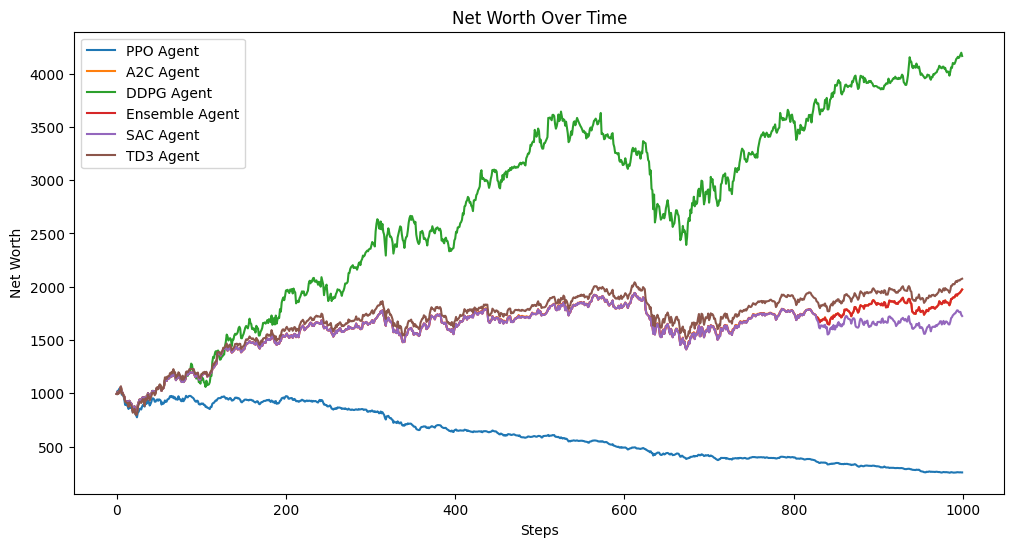

,Agent,Return,Standard Deviation,Sharpe Ratio
2,DDPG Agent,0.001608,0.018658,0.086169
5,TD3 Agent,0.000849,0.015322,0.055382
1,A2C Agent,0.000800,0.015101,0.052980
3,Ensemble Agent,0.000800,0.015101,0.052980
4,SAC Agent,0.000671,0.015512,0.043288
0,PPO Agent,-0.001414,0.012297,-0.114955


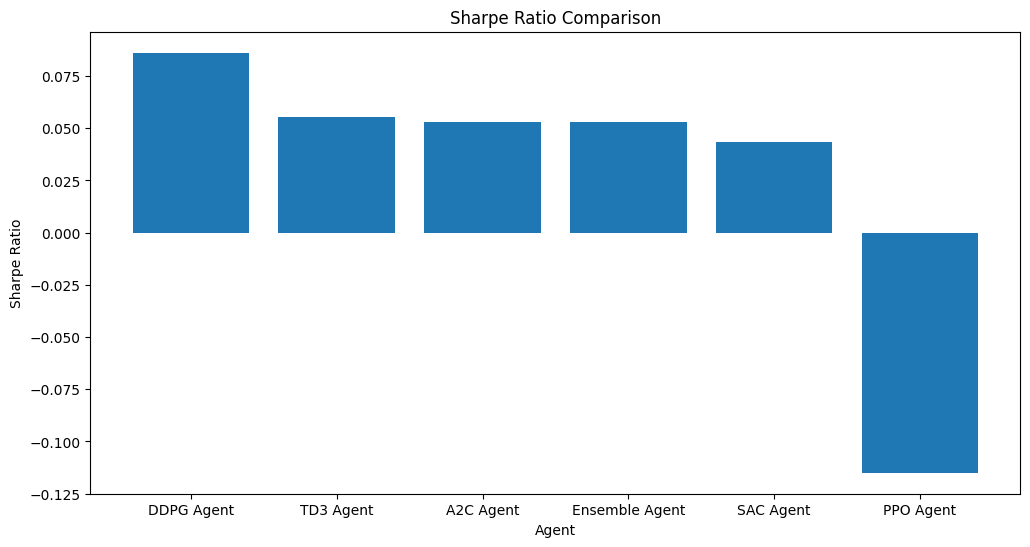

In [13]:
# 1. Create the environment and train the agents
total_timesteps = 10000
env, ppo_agent, a2c_agent, ddpg_agent, ensemble_agent, sac_agent, td3_agent = create_env_and_train_agents(training_data, total_timesteps)

# 2. Test & visualize the agents
n_tests = 1000
agents = {
    'PPO Agent': ppo_agent,
    'A2C Agent': a2c_agent,
    'DDPG Agent': ddpg_agent,
    'Ensemble Agent': ensemble_agent, 
    'SAC Agent': sac_agent,
    'TD3 Agent': td3_agent
}
test_and_visualize_agents(env, agents, training_data, n_tests=n_tests)


# 7. Testing Model - Ensemble + PPO + A2C + DDPG

Testing PPO Agent...


/Users/phamtheanh/miniconda3/lib/python3.11/site-packages/stable_baselines3/common/vec_env/base_vec_env.py:243: UserWarning: You tried to call render() but no `render_mode` was passed to the env constructor.
  warnings.warn("You tried to call render() but no `render_mode` was passed to the env constructor.")


Done testing PPO Agent!
Testing A2C Agent...
Done testing A2C Agent!
Testing DDPG Agent...
Done testing DDPG Agent!
Testing Ensemble Agent...
Done testing Ensemble Agent!
Testing SAC Agent...
Done testing SAC Agent!
Testing TD3 Agent...
Done testing TD3 Agent!
--------------------------------------------------
All agents tested!
--------------------------------------------------


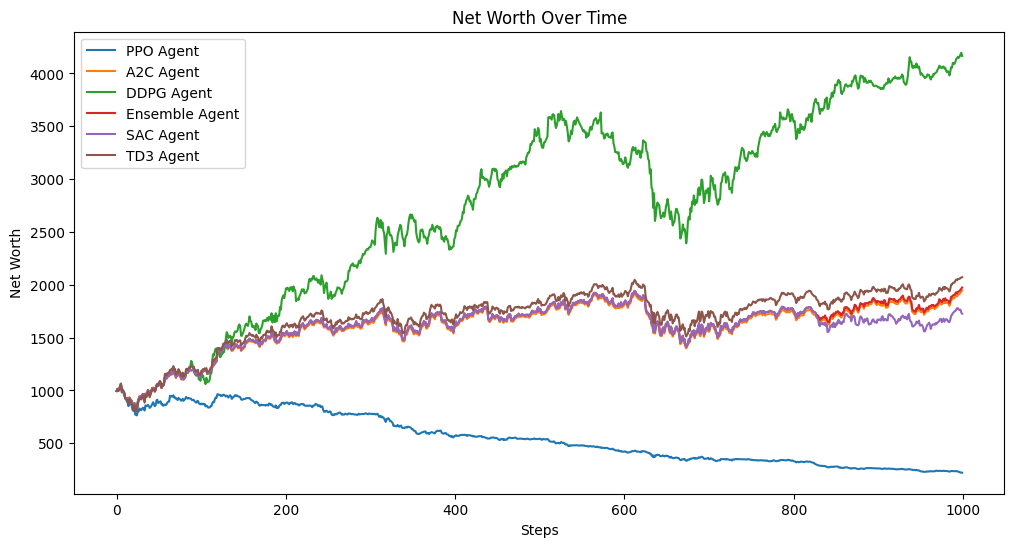

,Agent,Return,Standard Deviation,Sharpe Ratio
2,DDPG Agent,0.001608,0.018658,0.086169
5,TD3 Agent,0.001080,0.017991,0.060010
3,Ensemble Agent,0.000800,0.015101,0.052980
1,A2C Agent,0.000786,0.014974,0.052472
4,SAC Agent,0.000671,0.015512,0.043288
0,PPO Agent,-0.001435,0.012311,-0.116553


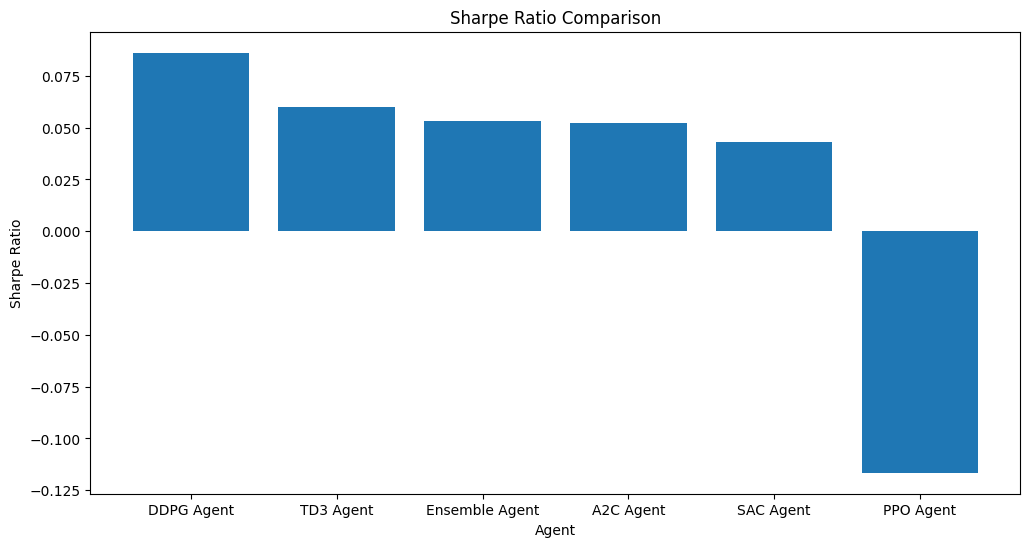

In [17]:
# Create the environment using DummyVecEnv with test data
test_env = DummyVecEnv([lambda: StockTradingEnv(test_data)])

# 2. Test & visualize the agents on the test data
n_tests = 1000
test_agents = {
    'PPO Agent': ppo_agent,
    'A2C Agent': a2c_agent,
    'DDPG Agent': ddpg_agent,
    'Ensemble Agent': ensemble_agent,
    'SAC Agent': sac_agent,
    'TD3 Agent': td3_agent
}
test_and_visualize_agents(env, test_agents, test_data, n_tests=n_tests)

# 3. Compare the agents' performance on the test data ( returns, standard deviation, and sharpe ratio )
test_agents_metrics = [test_agent(env, agent, test_data, n_tests=n_tests, visualize=False) for agent in test_agents.values()]
compare_and_plot_agents(test_agents_metrics, list(test_agents.keys()))